In [1]:
from __future__ import division

import sys
import os
import numpy as np
import pandas as pd
import datetime

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

# Experiment parameters
MA_TYPE = 'SMA'
COMPONENT = 'Chloride'
METHOD = 'RS1'
QC_RULES = ['13s','22s']

URefL = 106
LRefL = 99
UTL = 104
LTL =99
WINDOW = 50 


In [40]:
def df_to_series(df, method, qc=False, flags=False):
    
    if qc == False:
        # get the requested test and method and create a new DF
        df_ = df.loc[(df.Test != 'QC YH CHEM PANEL 1') & (df.Method == method)]
        test = 'val'
    elif qc == True:
        df_ = df.loc[(df.Test == 'QC YH CHEM PANEL 1') & (df.Method == method)]
        test = 'qc'


    else:
        print "Set qc flag: true if you want qc, false if you want result values"
        
    if flags == False:
        # take just the data and the value columns
        df_ = df_[['Verified','Value']]
    else:
        df_ = df_[['Verified','Decision']]



    try:
        if len(df_) != 0:
            # save to csv
            df_.to_csv('tmp.csv'.format(test, method), index=False)

            # read csv back in as a series
            series = pd.Series.from_csv('tmp.csv'.format(test, method),header=0)
        else:
            print(test)
            sys.exit("in df_to_series(): df_ was null")
            
    except Exception, e:
        print e 
        
    return series


def simple_moving_average(Window, ValTimeSeries):
    """
    Create a simple moving averages TimeSeries
    In: 
    -> Moving averages window
    -> TimeSeries of values
    Out: TimeSeries of MovingAverages for each of the supplied TimeStamps
    """
    
    ma_rs1_series = ValTimeSeries.copy(deep=True)
    for i in range(len(ValTimeSeries)):
        if i == 0:
            continue
        elif i < Window:
            ma_rs1_series[i] = ValTimeSeries[:i].mean()
        else:
            start = i - Window
            ma_rs1_series[i] = ValTimeSeries[start:i].mean()

    return ma_rs1_series


def moving_average_flags(MaTimeSeries, UTL, LTL):
    """
    Create a time series of moving average flags:
    1 = "Out"
    0 = "In"
    
    In: TimeSeries of moving average values
    Out: TimeSeries of 0 or 1 digits representing in and out respectively. 
    """
    
    ma_flag_series = MaTimeSeries.copy(deep=True)
    for i in range(len(MaTimeSeries)):

        if LTL <= MaTimeSeries[i] <= UTL:
            # in = 0
            ma_flag_series[i] = 0
        else: 
            # out = 1
            ma_flag_series[i] = 1
    return ma_flag_series


def moving_avg_performance_metrics(ma_perf_model, moving_avg_flag_series, qc_flag_series):
    """
    Takes flags from Moving Averages and QC and compares to get performance metrics
    
    Input: MA and QC flag timeseries'
    Output: Class object of: TP, FP, TN, FN, Precision, Recall
    """

    raw_perf_data = RawPerformanceModel()
    raw_perf_data.true_positive = 0
    raw_perf_data.false_positive = 0
    raw_perf_data.true_negative = 0
    raw_perf_data.false_negative = 0

    # TODO: Need to seperate logic for high and low MA flags
    # loop through all MA flags and compare to QC flags
    for i in range(len(moving_avg_flag_series)):

        # instantiate the time stamp of i'th MA_flag
        raw_perf_data.ma_flag_ts = moving_avg_flag_series.index[i]
        

        # Check MovingAverage "In" flags relative to QC
        # i.e. True Negatives and False Negatives
        if moving_avg_flag_series[i] == 0:
            
            # instantiate startQcLookup variable with i'th MA_flag
            startQcLookup = moving_avg_flag_series.index[i]
            
            for qc in qc_flag_series[startQcLookup:]:

                print (startQcLookup, qc_flag_series.index[0])
                
                raw_perf_data.qc_flag_ts = qc_flag_series[startQcLookup:].index[0]

                if qc == 0:
                    # 'True Negative'
                    raw_perf_data.true_negative+=1
                else:
                    # ma_flag = 0 & qc_flag = 1
                    # 'False Negative'
                    raw_perf_data.false_negative+=1

        # Check MovingAverage "Out" flags relative to QC
        # i.e. True Positives and False Positives
        else:
            startQcLookup = moving_avg_flag_series.index[i]
            for qc in qc_flag_series[startQcLookup:]:
                
                # add QC_Flag TimeStamp to MovingAvgPerformanceMetrics
                raw_perf_data.qc_flag_ts = qc_flag_series[startQcLookup:].index[0]
                
                if qc == 1:
                    # 'True Positive'
                    raw_perf_data.true_positive+=1
                else:
                    # ma_flag = 0 & qc_flag = 1
                    # 'False Positive'
                    raw_perf_data.false_positive+=1
                break
    
    print (raw_perf_data.ma_flag_ts, raw_perf_data.qc_flag_ts)
    # Calculate difference in time between QC flag and MA flag
    raw_perf_data.ma_qc_diff_secs = raw_perf_data.calculate_timestamp_diff()
    raw_perf_data.recall = raw_perf_data.calculate_recall()
    raw_perf_data.precision = raw_perf_data.calculate_precision()
    
    return raw_perf_data

def set_ma_experiment(ma_type, component, method, ma_window, qc_rules):
    
    ma = MovingAvgPerformanceModel()
    
    ma.component = component
    ma.chem_method = method
    ma.ma_type = ma_type
    ma.qc_rules = qc_rules
    
    return ma

In [3]:
class MovingAvgPerformanceModel:
    
    def __init__(self):

        self.component = str()
        self.chem_method = str()
        self.ma_type = str()
        self.qc_rules = list()
        self.exp_data = []
            
    # dumps Result object in json
    def tojson(self):
        return json.dumps(self, default=lambda o: o.__dict__,
                          sort_keys=False, indent=4)
    
class RawPerformanceModel:

    def __init__(self):

        # Ma/QC Parameters
        self.ma_utl = int()
        self.ma_ltl = int()
        self.ma_url = int()
        self.ma_lrl = int()
        self.ma_window = int()

        # Performance metrics
        self.true_positive = int()
        self.true_negative = int()
        self.false_positive = int()
        self.false_negative = int()
        self.precision = float()
        self.recall = float()

        # datetime("%Y-%m-%d %H:%M:%S")
        # 2017-01-15 00:15:00
        self.ma_flag_ts = str()
        self.qc_flag_ts = str()
        self.ma_qc_diff_secs = str()

    def calculate_timestamp_diff(self):
        return (self.qc_flag_ts - self.ma_flag_ts).seconds     

    def calculate_recall(self):
        return (self.true_positive / (self.true_positive + self.false_negative))

    def calculate_precision(self):
        return (self.true_positive / (self.true_positive + self.false_positive))
    

In [4]:
WORK_DIR = 'C:\\Users\\thoma\\Box Sync\\00Professional\\01Research\\01_Projects\\moving_average\\'
DATA_DIR = WORK_DIR + 'data\\'
OUT_DIR = WORK_DIR + 'out\\'

CSV_PATH = DATA_DIR + 'chloride_rs1_rs2_123016_012917.csv'

In [5]:
parse_dates = ['Received', 'Verified']
df = pd.read_csv(CSV_PATH, parse_dates=parse_dates)

In [26]:
df = df.sort_values(by='Verified')


# RESULT VALUES #######################################################

# Time series of all result values for a given method
rs1_val_series = df_to_series(df,'RS1', qc=False, flags=False)
norm_rs1_val_series = rs1_val_series[(rs1_val_series <= URefL) & (rs1_val_series >= LRefL)]
ma_rs1_series = simple_moving_average(WINDOW, norm_rs1_val_series)

# Time series of MA flags for a given series, UTL, and LTL
ma_flags = moving_average_flags(ma_rs1_series, 102, 100)

# QC VALUES ###########################################################

# time series of all QC values for a given method 
rs1_qc_series = df_to_series(df,'RS1', qc=True, flags=False)

# Time series of low QC values for a given method
low_rs1_qc_series = rs1_qc_series[rs1_qc_series <= 95]

# Time series of high QC values
high_rs1_qc_series = rs1_qc_series[rs1_qc_series >= 95]

# Time series of QC flags for a given method
qc_flags = df_to_series(df,'RS1', qc=True, flags=True)
qc_flags = qc_flags.replace(to_replace='Accept', value=0)
qc_flags = qc_flags.replace(to_replace='Reject', value=1)

print len(rs1_val_series)
print len(norm_rs1_val_series)
print len(ma_rs1_series)
print len(ma_flags)
print len(rs1_qc_series)
print len(low_rs1_qc_series)
print len(high_rs1_qc_series)
print len(qc_flags)

7316
4478
4478
4478
358
177
181
358


In [ ]:
ExperimentObject = set_ma_experiment(ma_type=MA_TYPE,
                                     component=COMPONENT,
                                     method=METHOD,
                                     ma_window=WINDOW,
                                     qc_rules=QC_RULES)

In [ ]:
# compare flags in moving averages with flags in QC
ExperimentObject.exp_data.append(moving_avg_performance_metrics(ma_perf_model=ExperimentObject,
                                                                moving_avg_flag_series=ma_flags,
                                                                qc_flag_series=qc_flags))
print ExperimentObject.__dict__

In [ ]:
for i in enumerate(ExperimentObject.exp_data):
    print i[1].__dict__

In [ ]:
import json
ExperimentObject_json = ExperimentObject.tojson()
ExperimentObject_dict = json.loads(ExperimentObject_json)

In [ ]:
ExperimentObject_dict['exp_data']

In [ ]:
csv.DictWriter?

In [ ]:
import csv
f = open('output.csv','wb')
w = csv.DictWriter(f)
w.writerows(ExperimentObject_dict['exp_data'])


# Visualize Stuff

In [47]:
ma_rs1_series.describe()

count    4478.000000
mean      102.099003
std         0.420282
min       100.960000
25%       101.820000
50%       102.140000
75%       102.360000
max       103.333333
Name: Value, dtype: float64

In [50]:
# Time series of MA flags for a given series, UTL, and LTL
ma_flags = moving_average_flags(ma_rs1_series, 103.3, 100.9)
print ma_flags.value_counts()

0.0    4477
1.0       1
Name: Value, dtype: int64


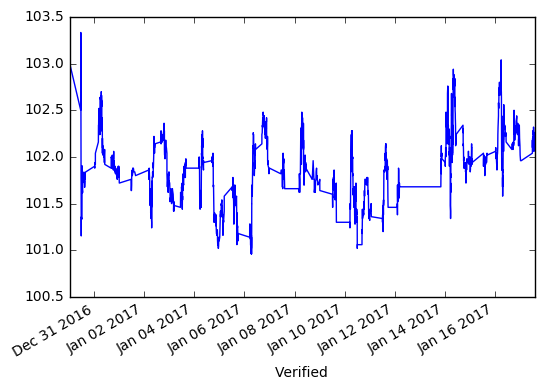

In [52]:
ma_rs1_series[:'2017-01-17 13:32:00'].plot()

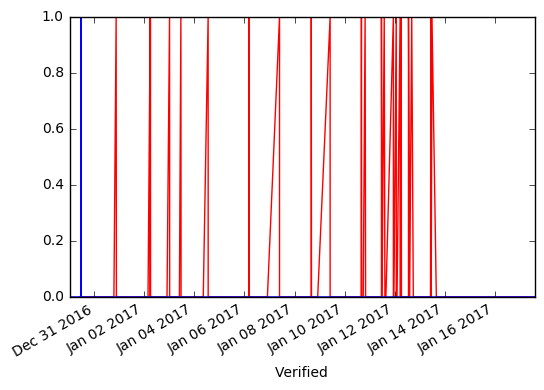

In [51]:
qc_flags[:'2017-01-17 13:32:00'].plot(color='red')
ma_flags[:'2017-01-17 13:32:00'].plot(color='blue')